In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Load the CSV file
df = pd.read_csv('大涌谷_整形済み.csv', encoding='utf-8')
df.head()

,Unnamed: 0,口コミ,投稿日
0,0,サザン茅ヶ崎コンサートの帰りにお泊まりしました。箱根パスでロープウェイも乗り降り自由だったの...,2023/10/2
1,1,子供ができてから初めての宿泊旅行で利用しました。子供が生後6ヶ月ということでウェルカムベビー...,2023/10/1
2,2,久しぶりのゆっくりした時間を過ごせたなぁ〜と終わりたかったのですが食事場所で足元が濡れていて...,2023/9/27
3,3,リピーターです。かれこれ5回以上は利用させてもらっているかと思います。部屋は古いながら掃除が...,2023/9/27
4,4,転職前の有休消化で奥さんと2人で、富士山が見える宿がうたい文句で泊まったものの、角部屋120...,2023/9/26


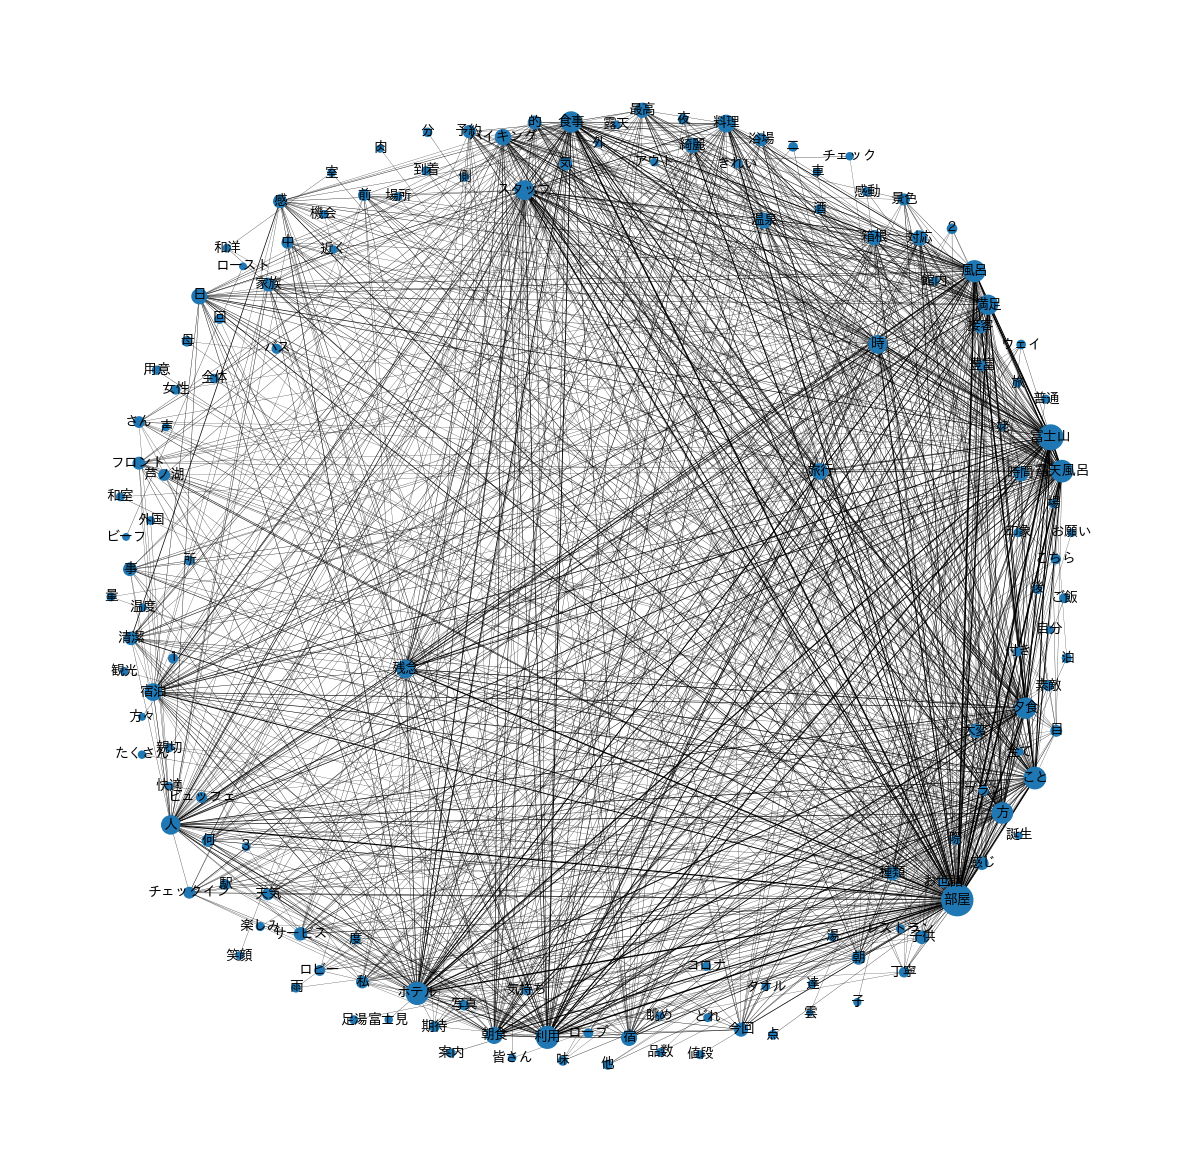

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import MeCab
import japanize_matplotlib
from sklearn.feature_extraction.text import CountVectorizer

# Define MeCab instance
mecab = MeCab.Tagger("-Ochasen")


top_n = 10

def count_cooccurrence(sents):
    count_model = CountVectorizer(token_pattern=r'\b\w+\b')
    X = count_model.fit_transform(sents)
    words = count_model.get_feature_names_out()
    word_counts = np.asarray(X.sum(axis=0)).reshape(-1)
    X[X > 0] = 1
    Xc = (X.T * X)
    return words, word_counts, Xc, X 

def extract_words(text, include_pos, stopwords):
    nodes = mecab.parse(text).split("\n")
    words = []
    for node in nodes:
        parts = node.split("\t")
        if len(parts) > 3:
            word, pos = parts[0], parts[3]
            if pos.startswith(include_pos) and word not in stopwords:
                words.append(word)
    return words

def word_weights(words, word_counts):
    count_max = word_counts.max()
    weights = [{'word': word, 'weight': count / count_max} for word, count in zip(words, word_counts)]
    return weights

def cooccurrence_weights(words, Xc, weight_cutoff):
    Xc_max = Xc.max()
    cutoff = weight_cutoff * Xc_max
    weights = [{'words': [words[i], words[j]], 'weight': Xc[i,j] / Xc_max} for i, j in zip(*Xc.nonzero()) if i < j and Xc[i,j] > cutoff]
    return weights

def create_network(words, word_counts, Xc, weight_cutoff):
    G = nx.Graph()
    weights_w = word_weights(words, word_counts)
    G.add_nodes_from((w['word'], {'weight': w['weight']}) for w in weights_w)
    weights_c = cooccurrence_weights(words, Xc, weight_cutoff)
    for wc in weights_c:
        G.add_edge(wc['words'][0], wc['words'][1], weight=wc['weight'])
    G.remove_nodes_from(list(nx.isolates(G)))
    return G

def pyplot_network(G):
    plt.figure(figsize=(15, 15))  # グラフのサイズを大きくする
    
    # kの値を調整して、ノード間の距離を変更します。
    pos = nx.spring_layout(G, k=2.0)
    
    # ノードのサイズとエッジの幅を調整するためのスケーリング係数を変更します。
    weights_n = np.array(list(nx.get_node_attributes(G, 'weight').values()))
    nx.draw_networkx_nodes(G, pos, node_size=500 * weights_n)
    
    weights_e = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
    nx.draw_networkx_edges(G, pos, width=3 * weights_e)
    
    # ラベルのフォントサイズを調整します。
    nx.draw_networkx_labels(G, pos, font_family='IPAexGothic', font_size=10)
    
    plt.axis("off")
    plt.show()

# 4. Parameters
include_pos = ('名詞',) # Considering only nouns for simplicity
# 既存のストップワード
stopwords = ('する', 'ある', 'ない', 'いう', 'もの', 'ところ', 'よう', 'これ', 'ため', 'それ', 'とき', 'それぞれ', 'これら', 'よる', 'くる','1','2','3','一','さ','い','の','し','いる','よかっ','き','おか','なり','くれ')

# 5. Extract words from reviews using MeCab
sents = []
empty_reviews = 0
for review in df["口コミ"]:
    extracted = extract_words(review, include_pos, stopwords)
    if not extracted:
        empty_reviews += 1
    sents.extend([' '.join(extracted)])

# 6. Compute cooccurrence
words, word_counts, Xc, X = count_cooccurrence(sents)
# 1. 高頻度ワードの確認
top_n = 10
sorted_indices = np.argsort(word_counts)[::-1]
top_words = [words[i] for i in sorted_indices[:top_n]]

# これらを stopwords に追加するか検討（以下ではとりあえず追加）
stopwords += tuple(top_words)

# 2. ネットワークの中心性を基にしたワードの確認
G = create_network(words, word_counts, Xc, 0.05)
centrality = nx.betweenness_centrality(G)
top_centrality_words = sorted(centrality, key=centrality.get, reverse=True)[:5]

# これらを stopwords に追加するか検討（以下ではとりあえず追加）
stopwords += tuple(top_centrality_words)

# 7. Generate the co-occurrence network
weight_cutoff = 0.05
G = create_network(words, word_counts, Xc, weight_cutoff)

# 8. Visualize the network using japanize_matplotlib
pyplot_network(G)